In [1]:
import theano
import theano.tensor as T
import lasagne
import numpy as np
import sklearn.datasets
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [ ]:
class LayerNormLayer(Layer):
    def __init__(self, incoming, axes='auto', epsilon=1e-4, alpha=0.1,
                 beta=init.Constant(0), gamma=init.Constant(1),
                 mean=init.Constant(0), inv_std=init.Constant(1), **kwargs):
        super(LayerNormLayer, self).__init__(incoming, **kwargs)

        if axes == 'auto':
            # default: normalize over all
            axes = tuple(range(0, len(self.input_shape)))
        elif isinstance(axes, int):
            axes = (axes,)
        self.axes = axes

        self.epsilon = epsilon
        self.alpha = alpha

        if beta is None:
            self.beta = None
        else:
            self.beta = self.add_param(beta, 'beta',
                                       trainable=True, regularizable=False)
        if gamma is None:
            self.gamma = None
        else:
            self.gamma = self.add_param(gamma, 'gamma',
                                        trainable=True, regularizable=True)
        self.mean = self.add_param(mean, 'mean',
                                   trainable=False, regularizable=False)
        self.inv_std = self.add_param(inv_std, 'inv_std',
                                      trainable=False, regularizable=False)

    def get_output_for(self, input, deterministic=False, **kwargs):
        input_mean = input.mean(self.axes)
        input_inv_std = T.inv(T.sqrt(input.var(self.axes) + self.epsilon))

        mean = input_mean
        inv_std = input_inv_std

        # prepare dimshuffle pattern inserting broadcastable axes as needed
        param_axes = iter(range(input.ndim - len(self.axes)))
        pattern = ['x' if input_axis in self.axes
                   else next(param_axes)
                   for input_axis in range(input.ndim)]

        # apply dimshuffle pattern to all parameters
        beta = 0 if self.beta is None else self.beta.dimshuffle(pattern)
        gamma = 1 if self.gamma is None else self.gamma.dimshuffle(pattern)
        mean = mean.dimshuffle(pattern)
        inv_std = inv_std.dimshuffle(pattern)

        # normalize
        normalized = (input - mean) * (gamma * inv_std) + beta
        return normalized

In [ ]:
class LayerNormLayer(Layer):
    def __init__(self, incoming, axes='auto', epsilon=1e-4, alpha=0.1,
                 beta=init.Constant(0), gamma=init.Constant(1),
                 mean=init.Constant(0), inv_std=init.Constant(1), **kwargs):
        super(LayerNormLayer, self).__init__(incoming, **kwargs)

        if axes == 'auto':
            # default: normalize over all
            axes = tuple(range(0, len(self.input_shape)))
        elif isinstance(axes, int):
            axes = (axes,)
        self.axes = axes

        self.epsilon = epsilon
        self.alpha = alpha

        if beta is None:
            self.beta = None
        else:
            self.beta = self.add_param(beta, 'beta',
                                       trainable=True, regularizable=False)
        if gamma is None:
            self.gamma = None
        else:
            self.gamma = self.add_param(gamma, 'gamma',
                                        trainable=True, regularizable=True)
        self.mean = self.add_param(mean, 'mean',
                                   trainable=False, regularizable=False)
        self.inv_std = self.add_param(inv_std, 'inv_std',
                                      trainable=False, regularizable=False)

    def get_output_for(self, input, deterministic=False, **kwargs):
        input_mean = input.mean(self.axes)
        input_inv_std = T.inv(T.sqrt(input.var(self.axes) + self.epsilon))

        mean = input_mean
        inv_std = input_inv_std

        # prepare dimshuffle pattern inserting broadcastable axes as needed
        param_axes = iter(range(input.ndim - len(self.axes)))
        pattern = ['x' if input_axis in self.axes
                   else next(param_axes)
                   for input_axis in range(input.ndim)]

        # apply dimshuffle pattern to all parameters
        beta = 0 if self.beta is None else self.beta.dimshuffle(pattern)
        gamma = 1 if self.gamma is None else self.gamma.dimshuffle(pattern)
        mean = mean.dimshuffle(pattern)
        inv_std = inv_std.dimshuffle(pattern)

        # normalize
        normalized = (input - mean) * (gamma * inv_std) + beta
        return normalized

In [ ]:
class LNGRULayer(MergeLayer):
    r"""
    .. math ::
        r_t = \sigma_r(LN(x_t, W_{xr}; \gamma_{xr}, \beta_{xr}) + LN(h_{t - 1}, W_{hr}; \gamma_{xr}, \beta_{xr}) + b_r)\\ \
        u_t = \sigma_u(LN(x_t, W_{xu}; \gamma_{xu}, \beta_{xu}) + LN(h_{t - 1}, W_{hu}; \gamma_{xu}, \beta_{xu})+ b_u)\\ \
        c_t = \sigma_c(LN(x_t, W_{xc}; \gamma_{xc}, \beta_{xc}) + r_t \odot (LN(h_{t - 1}, W_{hc}); \gamma_{xc}, \beta_{xc}) + b_c)\\ \
        h_t = (1 - u_t) \odot h_{t - 1} + u_t \odot c_t \

    Notes
    -----

    .. math::
        LN(z;\alpha, \beta) = \frac{(z-\mu)}{\sigma} \odot \alpha + \beta

    """
    def __init__(self, incoming, num_units,
                 resetgate=Gate(W_cell=None),
                 updategate=Gate(W_cell=None),
                 hidden_update=Gate(W_cell=None,
                                    nonlinearity=nonlinearities.tanh),
                 hid_init=init.Constant(0.),
                 backwards=False,
                 learn_init=False,
                 gradient_steps=-1,
                 grad_clipping=0,
                 unroll_scan=False,
                 precompute_input=True,
                 mask_input=None,
                 only_return_final=False,
                 alpha_init=init.Constant(1.0),
                 beta_init=init.Constant(0.0),
                 normalize_hidden_update=False,
                 **kwargs):

        # This layer inherits from a MergeLayer, because it can have three
        # inputs - the layer input, the mask and the initial hidden state.  We
        # will just provide the layer input as incomings, unless a mask input
        # or initial hidden state was provided.
        incomings = [incoming]
        self.mask_incoming_index = -1
        self.hid_init_incoming_index = -1
        if mask_input is not None:
            incomings.append(mask_input)
            self.mask_incoming_index = len(incomings)-1
        if isinstance(hid_init, Layer):
            incomings.append(hid_init)
            self.hid_init_incoming_index = len(incomings)-1

        # Initialize parent layer
        super(LNGRULayer, self).__init__(incomings, **kwargs)

        # # If the provided nonlinearity is None, make it linear
        # if nonlinearity is None:
        #     self.nonlinearity = nonlinearities.identity
        # else:
        #     self.nonlinearity = nonlinearity

        self.learn_init = learn_init
        self.num_units = num_units
        self.grad_clipping = grad_clipping
        self.backwards = backwards
        self.gradient_steps = gradient_steps
        self.unroll_scan = unroll_scan
        self.precompute_input = precompute_input
        self.only_return_final = only_return_final

        self.alpha_init = alpha_init
        self.beta_init = beta_init
        self.normalize_hidden_update = normalize_hidden_update
        self._eps = 1e-5

        if unroll_scan and gradient_steps != -1:
            raise ValueError(
                "Gradient steps must be -1 when unroll_scan is true.")

        # Retrieve the dimensionality of the incoming layer
        input_shape = self.input_shapes[0]

        if unroll_scan and input_shape[1] is None:
            raise ValueError("Input sequence length cannot be specified as "
                             "None when unroll_scan is True")

        # Input dimensionality is the output dimensionality of the input layer
        num_inputs = np.prod(input_shape[2:])

        def add_gate_params(gate, gate_name):
            """ Convenience function for adding layer parameters from a Gate
            instance. """
            return (self.add_param(gate.W_in, (num_inputs, num_units),
                                   name="W_in_to_{}".format(gate_name)),
                    self.add_param(gate.W_hid, (num_units, num_units),
                                   name="W_hid_to_{}".format(gate_name)),
                    self.add_param(gate.b, (num_units,),
                                   name="b_{}".format(gate_name),
                                   regularizable=False),
                    self.add_param(self.alpha_init, (num_units,),
                                   name="alpha_in_to_{}".format(gate_name)),
                    self.add_param(self.beta_init, (num_units,),
                                   name="beta_in_to_{}".format(gate_name),
                                   regularizable=False),
                    self.add_param(self.alpha_init, (num_units,),
                                   name="alpha_hid_to_{}".format(gate_name)),
                    self.add_param(self.beta_init, (num_units,),
                                   name="beta_hid_to_{}".format(gate_name),
                                   regularizable=False),
                    gate.nonlinearity)

        # Add in all parameters from gates
        (self.W_in_to_updategate, self.W_hid_to_updategate, self.b_updategate,
         self.alpha_in_to_updategate, self.beta_in_to_updategate,
         self.alpha_hid_to_updategate, self.beta_hid_to_updategate,
         self.nonlinearity_updategate) = add_gate_params(updategate, 'updategate')

        (self.W_in_to_resetgate, self.W_hid_to_resetgate, self.b_resetgate,
         self.alpha_in_to_resetgate, self.beta_in_to_resetgate,
         self.alpha_hid_to_resetgate, self.beta_hid_to_resetgate,
         self.nonlinearity_resetgate) = add_gate_params(resetgate, 'resetgate')

        (self.W_in_to_hidden_update, self.W_hid_to_hidden_update, self.b_hidden_update, 
         self.alpha_in_to_hidden_update, self.beta_in_to_hidden_update,
         self.alpha_hid_to_hidden_update, self.beta_hid_to_hidden_update,
         self.nonlinearity_hidden_update) = add_gate_params(hidden_update, 'hidden_update')

        # Initialize hidden state
        if isinstance(hid_init, Layer):
            self.hid_init = hid_init
        else:
            self.hid_init = self.add_param(
                hid_init, (1, self.num_units), name="hid_init",
                trainable=learn_init, regularizable=False)

        # parameters for Layer Normalization of the cell gate
        if self.normalize_hidden_update:
            self.alpha_hidden_update = self.add_param(
                self.alpha_init, (num_units, ),
                name="alpha_hidden_update")
            self.beta_hidden_update = self.add_param(
                self.beta_init, (num_units, ),
                name="beta_hidden_update", regularizable=False)

    def get_output_shape_for(self, input_shapes):
        # The shape of the input to this layer will be the first element
        # of input_shapes, whether or not a mask input is being used.
        input_shape = input_shapes[0]
        # When only_return_final is true, the second (sequence step) dimension
        # will be flattened
        if self.only_return_final:
            return input_shape[0], self.num_units
        # Otherwise, the shape will be (n_batch, n_steps, num_units)
        else:
            return input_shape[0], input_shape[1], self.num_units

    # Layer Normalization
    def __ln__(self, z, alpha, beta):
        output = (z - z.mean(-1, keepdims=True)) / T.sqrt(z.var(-1, keepdims=True) + self._eps)
        output = alpha * output + beta
        return output


    def __gru_fun__(self, inputs, **kwargs):
        """
        """
        # Retrieve the layer input
        input = inputs[0]
        # Retrieve the mask when it is supplied
        mask = None
        hid_init = None
        if self.mask_incoming_index > 0:
            mask = inputs[self.mask_incoming_index]
        if self.hid_init_incoming_index > 0:
            hid_init = inputs[self.hid_init_incoming_index]

        # Treat all dimensions after the second as flattened feature dimensions
        if input.ndim > 3:
            input = T.flatten(input, 3)

        # Because scan iterates over the first dimension we dimshuffle to
        # (n_time_steps, n_batch, n_features)
        input = input.dimshuffle(1, 0, 2)
        seq_len, num_batch, _ = input.shape

        # Stack input weight matrices into a (num_inputs, 3*num_units)
        # matrix, which speeds up computation
        W_in_stacked = T.concatenate(
            [self.W_in_to_resetgate, self.W_in_to_updategate,
             self.W_in_to_hidden_update], axis=1)

        # Stack alphas for input into a (3*num_units) vector
        alpha_in_stacked = T.concatenate(
            [self.alpha_in_to_resetgate, self.alpha_in_to_updategate,
             self.alpha_in_to_hidden_update], axis=0)

        # Stack betas for input into a (3*num_units) vector
        beta_in_stacked = T.concatenate(
            [self.beta_in_to_resetgate, self.beta_in_to_updategate,
             self.beta_in_to_hidden_update], axis=0)

        # Same for hidden weight matrices
        W_hid_stacked = T.concatenate(
            [self.W_hid_to_resetgate, self.W_hid_to_updategate,
             self.W_hid_to_hidden_update], axis=1)

        # Stack alphas for hidden into a (3*num_units) vector
        alpha_hid_stacked = T.concatenate(
            [self.alpha_hid_to_resetgate, self.alpha_hid_to_updategate,
             self.alpha_hid_to_hidden_update], axis=0)

        # Stack betas for hidden into a (3*num_units) vector
        beta_hid_stacked = T.concatenate(
            [self.beta_hid_to_resetgate, self.beta_hid_to_updategate,
             self.beta_hid_to_hidden_update], axis=0)

        # Stack gate biases into a (3*num_units) vector
        b_stacked = T.concatenate(
            [self.b_resetgate, self.b_updategate,
             self.b_hidden_update], axis=0)

        if self.precompute_input:
            # precompute_input inputs*W. W_in is (n_features, 3*num_units).
            # input is then (n_batch, n_time_steps, 3*num_units).
            big_ones = T.ones((seq_len, num_batch, 1))
            input = T.dot(input, W_in_stacked)
            input = self.__ln__(input,
                                T.dot(big_ones, alpha_in_stacked.dimshuffle('x', 0)),
                                beta_in_stacked) + b_stacked
        
        ones = T.ones((num_batch, 1))
        # At each call to scan, input_n will be (n_time_steps, 3*num_units).
        # We define a slicing function that extract the input to each GRU gate
        def slice_w(x, n):
            return x[:, n*self.num_units:(n+1)*self.num_units]

        # Create single recurrent computation step function
        # input__n is the n'th vector of the input
        def step(input_n, hid_previous, *args):
            if not self.precompute_input:
                # Compute W_{xr}x_t + b_r, W_{xu}x_t + b_u, and W_{xc}x_t + b_c
                input_n = T.dot(input_n, W_in_stacked)
                input_n = self.__ln__(input_n,
                                      T.dot(ones, alpha_in_stacked.dimshuffle('x', 0)),
                                      beta_in_stacked) + b_stacked

            # Compute W_{hr} h_{t - 1}, W_{hu} h_{t - 1}, and W_{hc} h_{t - 1}
            hid_input = T.dot(hid_previous, W_hid_stacked)
            hid_input = self.__ln__(hid_input,
                                    T.dot(ones, alpha_hid_stacked.dimshuffle('x', 0)),
                                    beta_hid_stacked)

            # Reset and update gates
            resetgate = slice_w(hid_input, 0) + slice_w(input_n, 0)
            updategate = slice_w(hid_input, 1) + slice_w(input_n, 1)
            if self.grad_clipping:
                resetgate = theano.gradient.grad_clip(
                    resetgate, -self.grad_clipping, self.grad_clipping)
                updategate = theano.gradient.grad_clip(
                    updategate, -self.grad_clipping, self.grad_clipping)

            resetgate = self.nonlinearity_resetgate(resetgate)
            updategate = self.nonlinearity_updategate(updategate)

            # Compute W_{xc}x_t + r_t \odot (W_{hc} h_{t - 1})
            hidden_update_in = slice_w(input_n, 2)
            hidden_update_hid = slice_w(hid_input, 2)
            hidden_update = hidden_update_in + resetgate*hidden_update_hid
            if self.grad_clipping:
                hidden_update = theano.gradient.grad_clip(
                    hidden_update, -self.grad_clipping, self.grad_clipping)
            hidden_update = self.nonlinearity_hidden_update(hidden_update)

            if self.normalize_hidden_update:
                hidden_update = self.__ln__(hidden_update,
                                   T.dot(ones, self.alpha_hidden_update.dimshuffle('x', 0)),
                                   self.beta_hidden_update)
            # Compute (1 - u_t)h_{t - 1} + u_t c_t
            hid = (1 - updategate)*hid_previous + updategate*hidden_update
            return hid

        def step_masked(input_n, mask_n, hid_previous, *args):
            hid = step(input_n, hid_previous, *args)

            # Skip over any input with mask 0 by copying the previous
            # hidden state; proceed normally for any input with mask 1.
            hid = T.switch(mask_n, hid, hid_previous)

            return hid

        if mask is not None:
            # mask is given as (batch_size, seq_len). Because scan iterates
            # over first dimension, we dimshuffle to (seq_len, batch_size) and
            # add a broadcastable dimension
            mask = mask.dimshuffle(1, 0, 'x')
            sequences = [input, mask]
            step_fun = step_masked
        else:
            sequences = [input]
            step_fun = step

        if not isinstance(self.hid_init, Layer):
            # Dot against a 1s vector to repeat to shape (num_batch, num_units)
            hid_init = T.dot(T.ones((num_batch, 1)), self.hid_init)

        # The hidden-to-hidden weight matrix is always used in step
        non_seqs = [W_hid_stacked, alpha_hid_stacked, beta_hid_stacked]
        # When we aren't precomputing the input outside of scan, we need to
        # provide the input weights and biases to the step function
        if not self.precompute_input:
            non_seqs += [W_in_stacked, b_stacked, alpha_in_stacked, beta_in_stacked]

        if self.unroll_scan:
            # Retrieve the dimensionality of the incoming layer
            input_shape = self.input_shapes[0]
            # Explicitly unroll the recurrence instead of using scan
            hid_out = unroll_scan(
                fn=step_fun,
                sequences=sequences,
                outputs_info=[hid_init],
                go_backwards=self.backwards,
                non_sequences=non_seqs,
                n_steps=input_shape[1])[0]
        else:
            # Scan op iterates over first dimension of input and repeatedly
            # applies the step function
            hid_out = theano.scan(
                fn=step_fun,
                sequences=sequences,
                go_backwards=self.backwards,
                outputs_info=[hid_init],
                non_sequences=non_seqs,
                truncate_gradient=self.gradient_steps,
                strict=False)[0]

        return hid_out


    def get_output_for(self, inputs, **kwargs):
        # When it is requested that we only return the final sequence step,
        # we need to slice it out immediately after scan is applied
        hid_out = self.__gru_fun__(inputs, **kwargs)
        if self.only_return_final:
            hid_out = hid_out[-1]
        else:
            # dimshuffle back to (n_batch, n_time_steps, n_features))
            hid_out = hid_out.dimshuffle(1, 0, 2)

            # if scan is backward reverse the output
            if self.backwards:
                hid_out = hid_out[:, ::-1]

        return hid_out

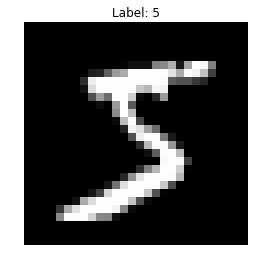

In [2]:
# We'll use the load_data function from the mnist.py example
from mnist import load_dataset
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()
# Create a dataset dictionary for convenience
dataset = {
    'train': {'X': X_train, 'y': y_train},
    'valid': {'X': X_valid, 'y': y_valid}}
# Plot an example digit with its label
plt.imshow(dataset['train']['X'][0][0], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(dataset['train']['y'][0]))
plt.gca().set_axis_off()

In [17]:
# We'll determine the input shape from the first example from the training set.
input_shape = dataset['train']['X'][0].shape
l_in = lasagne.layers.InputLayer(
    shape=(None, input_shape[0], input_shape[1], input_shape[2]))

# Create the first convolutional layer
l_conv1 = lasagne.layers.Conv2DLayer(
    l_in,
    # Here, we set the number of filters and their size.
    num_filters=32, filter_size=(5, 5),
    # lasagne.nonlinearities.rectify is the common ReLU nonlinearity
    nonlinearity=lasagne.nonlinearities.rectify,
    # Use He et. al.'s initialization
    W=lasagne.init.HeNormal(gain='relu'))
l_conv1_ln = lasagne.layers.normalization.layer_norm(l_conv1)
# Other arguments: Convolution type (full, same, or valid) and stride

# Here, we do 2x2 max pooling.  The max pooling layer also supports striding
l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1_ln, pool_size=(2, 2))


# The second convolution/pooling pair is the same as above.
l_conv2 = lasagne.layers.Conv2DLayer(
    l_pool1, num_filters=32, filter_size=(5, 5),
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))
l_conv2_ln = lasagne.layers.normalization.layer_norm(l_conv2)

l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2_ln, pool_size=(2, 2))

# p is the dropout probability
#l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)
l_hidden1_reshape = lasagne.layers.ReshapeLayer(l_pool2, (l_in.input_var.shape[0], 32, 16))
l_gru1 = lasagne.layers.LNGRULayer(l_hidden1_reshape, 30, grad_clipping=10, only_return_final=False)
l_gru2 = lasagne.layers.LNGRULayer(l_hidden1_reshape, 30, grad_clipping=10, only_return_final=False, backwards=True)
l_bgru = lasagne.layers.ConcatLayer([l_gru1, l_gru2], axis=2)

l_hidden1 = lasagne.layers.DenseLayer(
    l_bgru, num_units=256, 
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))
l_output = lasagne.layers.DenseLayer(
    l_hidden1,
    # The number of units in the softmas output layer is the number of classes.
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

In [21]:
test_l_pool2 = theano.function([l_in.input_var],
                             lasagne.layers.get_output(l_bgru, deterministic=True))

In [22]:
m =dataset['train']['X'][0:100]
n = test_l_pool2(m)

In [23]:
n.shape

(100, 32, 60)

In [15]:
true_output = T.ivector('true_output')

# As mentioned above, when using dropout we should define different losses:
# One for training, one for evaluation.  The training loss should apply dropout,
# while the evaluation loss shouldn't.  This is controlled by setting get_output's deterministic kwarg.
loss_train = T.mean(lasagne.objectives.categorical_crossentropy(
        lasagne.layers.get_output(l_output, deterministic=False), true_output))
loss_eval = T.mean(lasagne.objectives.categorical_crossentropy(
        lasagne.layers.get_output(l_output, deterministic=True), true_output))

all_params = lasagne.layers.get_all_params(l_output, trainable=True)
# Use ADADELTA for updates
updates = lasagne.updates.adadelta(loss_train, all_params)
train = theano.function([l_in.input_var, true_output], loss_train, updates=updates)

# This is the function we'll use to compute the network's output given an input
# (e.g., for computing accuracy).  Again, we don't want to apply dropout here
# so we set the deterministic kwarg to True.
get_output = theano.function([l_in.input_var],
                             lasagne.layers.get_output(l_output, deterministic=True))

In [16]:
# Now, let's train it!  We'll chop the training data into mini-batches,
# and compute the validation accuracy every epoch.
BATCH_SIZE = 100
N_EPOCHS = 10
# Keep track of which batch we're training with
batch_idx = 0
# Keep track of which epoch we're on
epoch = 0
while epoch < N_EPOCHS:
    # Extract the training data/label batch and update the parameters with it
    train(dataset['train']['X'][batch_idx:batch_idx + BATCH_SIZE],
          dataset['train']['y'][batch_idx:batch_idx + BATCH_SIZE])
    batch_idx += BATCH_SIZE
    # Once we've trained on the entire training set...
    if batch_idx >= dataset['train']['X'].shape[0]:
        # Reset the batch index
        batch_idx = 0
        # Update the number of epochs trained
        epoch += 1
        # Compute the network's output on the validation data
        val_output = get_output(dataset['valid']['X'])
        # The predicted class is just the index of the largest probability in the output
        val_predictions = np.argmax(val_output, axis=1)
        # The accuracy is the average number of correct predictions
        accuracy = np.mean(val_predictions == dataset['valid']['y'])
        print("Epoch {} validation accuracy: {}".format(epoch, accuracy))

Epoch 1 validation accuracy: 0.9794
Epoch 2 validation accuracy: 0.9851
Epoch 3 validation accuracy: 0.987
Epoch 4 validation accuracy: 0.9886
Epoch 5 validation accuracy: 0.9882
Epoch 6 validation accuracy: 0.9885
Epoch 7 validation accuracy: 0.9897
Epoch 8 validation accuracy: 0.9897
Epoch 9 validation accuracy: 0.9902
Epoch 10 validation accuracy: 0.9908
